In [ ]:
# 

## nav_msgs/Odometry Message

```yaml
std_msgs/Header header
string child_frame_id
geometry_msgs/PoseWithCovariance pose
geometry_msgs/TwistWithCovariance twist
```



## geometry_msgs/PointStamped

```yaml
std_msgs/Header header
geometry_msgs/Point point
```

In [1]:
#%matplotlib inline
%matplotlib notebook

<IPython.core.display.Javascript object>


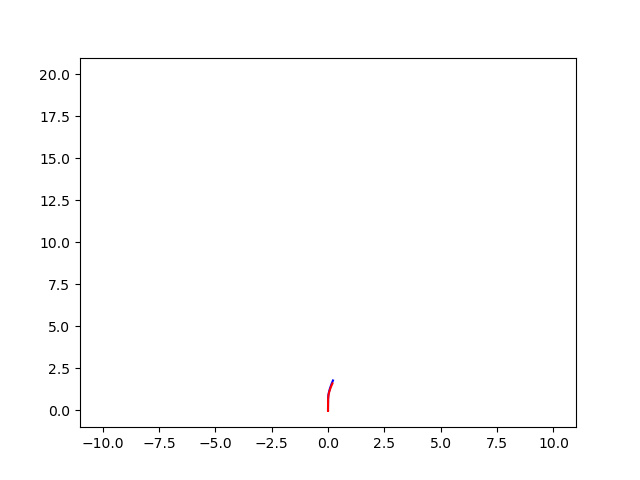

tachy: -0.4752401352747695 | odom: 0.0
tachy: -0.4752401352747695 | odom: 0.0
tachy: 0.9604920020873748 | odom: 0.0
tachy: -2.880409128991095 | odom: 0.0
tachy: 2.621552001584481 | odom: 0.0
tachy: -0.642024628467755 | odom: 0.0
tachy: -0.5232257962376684 | odom: 0.0
tachy: 2.5197593581900435 | odom: 0.0
tachy: -0.6069684952945679 | odom: 0.0
tachy: -0.5900468429205479 | odom: 0.0
tachy: 2.599433308044682 | odom: 0.0
tachy: -0.6666194216289705 | odom: 0.0
tachy: -0.5109950744691983 | odom: 0.0
tachy: 2.5265030375018913 | odom: 0.0
tachy: -0.5993833713221699 | odom: 0.0
tachy: 2.5428724628209536 | odom: 0.0
tachy: -2.1220409301915004 | odom: 1.1648207775474322e-15
tachy: 2.898491073471546 | odom: 0.00044312124890655936
tachy: -0.03763053435504654 | odom: 0.0009147633747553084
tachy: 0.04524147059855056 | odom: 0.0009195609254679725
tachy: 0.011551783316526832 | odom: 0.0005548870403551509
tachy: 0.02607665229222345 | odom: 0.0010345982321388555
tachy: -0.010264411515831802 | odom: -0.00

In [ ]:
import rospy
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

from std_msgs.msg import String
from sensor_msgs.msg import JointState
from nav_msgs.msg import Odometry
from geometry_msgs.msg import PointStamped

from tf.transformations import euler_from_quaternion, quaternion_from_euler


class Tachymeter(PointStamped):

    # Init values, as provided by very first message (of rosbag: akig_husky_tachy_fahrt3.bag)
    # [X-axis, Y-axis, heading], inital heading needs to be set 
    # (we measure the Huskys-Nests for that) or approx. with 0
    # Following heading can be calculated by coordiante differential to message got earlier
    # we havent payed attention to base_link to P360 leverarm yet! (maybe to that after tf usage)
    tachy_ = np.array([[(-1)*2.293186351691284,1.5719709616827098,0]])
    
    def callback(self, msg):
        tachy_heading = 0
        # heading derived from measured target
        if self.tachy_.shape[0] > 1:
            dx = self.tachy_[self.tachy_.shape[0]-1,0] - self.tachy_[self.tachy_.shape[0]-2,0]
            dy = self.tachy_[self.tachy_.shape[0]-1,1] - self.tachy_[self.tachy_.shape[0]-2,1]
            tachy_heading = np.arctan2(dy,dx)
        self.tachy_ = np.vstack((self.tachy_, np.array([(-1)*msg.point.x, msg.point.y, tachy_heading])))

class HuskyOdometry(Odometry):
    # init values. Following the odometry principle, we should always start with [0,0,0]
    odom_ = np.array([[0,0,0]])

    def callback(self, msg):
        #print(msg.header.stamp.secs)

        orientation_q = msg.pose.pose.orientation
        orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
        (roll, pitch, yaw) = euler_from_quaternion (orientation_list)

        self.odom_ = np.vstack((self.odom_, np.array([msg.pose.pose.position.x, (-1)*msg.pose.pose.position.y, yaw])))

        
                                   
if __name__ == '__main__':
    try:
        rospy.init_node('husky_odometry', anonymous=True)
        
        odom = HuskyOdometry()
        pos = Tachymeter()

        odom_sub = rospy.Subscriber('/odometry/filtered', Odometry, odom.callback)
        tachy_sub = rospy.Subscriber('/tachy_points', PointStamped, pos.callback)

        plt.ion()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # Set plot plane size according to bag file inspected
        odom_line, = ax.plot([-10, 10],[0, 20], 'b-')
        tachy_line, = ax.plot([-10, 10],[0, 20], 'r-')
        # give matplotlib some time 
        rospy.sleep(0.1)
        while not rospy.is_shutdown():
            # Check whether there is enough data yet, as we need to initilize first
            is_tachy_empty = pos.tachy_.size > 6
            is_odom_empty = odom.odom_.size > 6

            if ( is_tachy_empty and is_odom_empty ):

                odom_line.set_xdata(odom.odom_[:,1])
                odom_line.set_ydata(odom.odom_[:,0])

                # reduce tachy measurement by init position
                tachy_line.set_xdata(pos.tachy_[:,1]-pos.tachy_[0,1])
                tachy_line.set_ydata(pos.tachy_[:,0]-pos.tachy_[0,0])

                fig.canvas.draw()
                fig.canvas.flush_events()

                
                print("tachy: " + str(pos.tachy_[pos.tachy_.shape[0]-1,2]) + " | odom: " + str(odom.odom_[odom.odom_.shape[0]-1,2]))
                
            rospy.sleep(0.1)
                
                

            


    except rospy.ROSInterruptException:
        pass